In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
testData = tf.keras.utils.image_dataset_from_directory(
    directory = "SpectrogramData_Formatted/test",
    labels="inferred",
    label_mode = "categorical",
    color_mode="rgb",
    batch_size=64,
    image_size=(235, 352),
    shuffle=False,
    seed=42
)


Found 495 files belonging to 5 classes.


In [4]:
import keras.backend as K

def macro_f1_score(y_true, y_pred):
    """
    Calculate macro-average F1 score using Keras backend.

    Parameters:
        y_true (tensor or array): The true class labels (ground truth) as a tensor or Numpy array.
        y_pred (tensor or array): The predicted class labels as a tensor or Numpy array.

    Returns:
        float: The macro-average F1 score.
    """
    # Convert Numpy arrays to Keras backend tensors
    if not tf.is_tensor(y_true):
        y_true = K.constant(y_true)

    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    
    # Calculate true positives, false positives, and false negatives for each class
    tp = K.sum(y_true * K.round(y_pred), axis=0)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # Calculate precision and recall for each class
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calculate macro-average F1 score
    macro_f1 = K.mean(f1_score)

    return macro_f1

In [6]:
############ Baseline ############
savedModelBaseline = tf.keras.models.load_model("Results/SavedModels/best_model_baseline.h5", compile=False)
savedModelBaseline.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelBaseline.evaluate(testData)
print("Baseline")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


############ Aug1 ############
savedModelAug1 = tf.keras.models.load_model("Results/SavedModels/best_model_Aug1.h5", compile=False)
savedModelAug1.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelAug1.evaluate(testData)
print("Aug1")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


############ Aug 2 ############
savedModelAug2 = tf.keras.models.load_model("Results/SavedModels/best_model_Aug2.h5", compile=False)
savedModelAug2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelAug2.evaluate(testData)
print("Aug2")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


8/8 [==============================] - 25s 3s/step - loss: 1.2198 - accuracy: 0.5636 - macro_f1_score: 0.1071
Baseline
Loss: 1.219831943511963
macro_f1_score:  10.71 %
Accuracy:  56.36 %
8/8 [==============================] - 27s 3s/step - loss: 1.1506 - accuracy: 0.5798 - macro_f1_score: 0.1704
Aug1
Loss: 1.1505711078643799
macro_f1_score:  17.04 %
Accuracy:  57.98 %
8/8 [==============================] - 6s 605ms/step - loss: 2.0798 - accuracy: 0.5212 - macro_f1_score: 0.1755
Aug2
Loss: 2.079796075820923
macro_f1_score:  17.55 %
Accuracy:  52.12 %


# RNN Timestep Analysis

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img('SpectrogramData_Formatted/test/Electric/13706.png', target_size=(235, 352))
img_array = img_to_array(img) / 255.0  # Normalize to 0-1 if that's what the model expects
# Expand dimensions to add the batch size dimension
img_array = np.expand_dims(img_array, axis=0)

TimestepBaseline = savedModelBaseline.predict(img_array)

class_indices = np.argmax(TimestepBaseline, axis=1)  # For multiclass classification
print(TimestepBaseline)
class_labels = testData.class_names


# Convert class indices to labels
predicted_labels = np.vectorize(lambda idx: class_labels[idx])(class_indices)

# Map class indices to names
#predicted_labels = [class_names[idx] for idx in class_indices]
print(predicted_labels)

# Plots (Accuracy, F1-score, Loss)

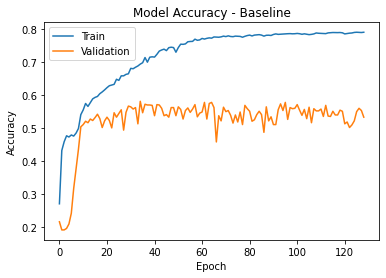

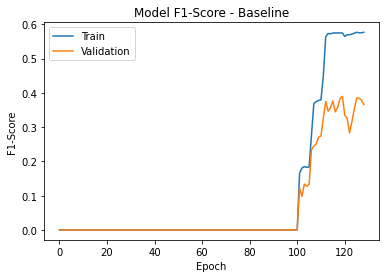

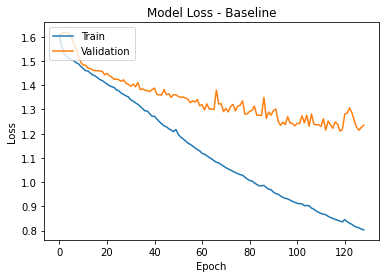

In [10]:
baselineMetrics = pd.read_csv("Results/Baseline_metrics.csv")
aug1Metrics = pd.read_csv("Results/Aug1_metrics.csv")
aug2Metrics = pd.read_csv("Results/Aug2_metrics.csv")

# https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
import matplotlib.pyplot as plt

model = baselineMetrics
modelName = "Baseline"

# summarize history for accuracy
plt.plot(model["accuracy"])
plt.plot(model['val_accuracy'])
plt.title("Model Accuracy - "+modelName)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Results/Plots/Metric_Plots/"+modelName+"_Accuracy", bbox_inches="tight")
plt.show()


# summarize history for f1-score
plt.plot(model["macro_f1_score"])
plt.plot(model['val_macro_f1_score'])
plt.title("Model F1-Score - "+modelName)
plt.ylabel("F1-Score")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Results/Plots/Metric_Plots/"+modelName+"_F1-score", bbox_inches="tight")
plt.show()


# summarize history for loss
plt.plot(model["loss"])
plt.plot(model['val_loss'])
plt.title("Model Loss - "+modelName)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Results/Plots/Metric_Plots/"+modelName+"_Loss", bbox_inches="tight")
plt.show()

# Confusion Matrix

In [ ]:
#https://datascience.stackexchange.com/questions/95009/good-model-but-bad-confusion-matrix

## Baseline

8/8 [==============================] - 29s 4s/step
Found 495 images belonging to 5 classes.


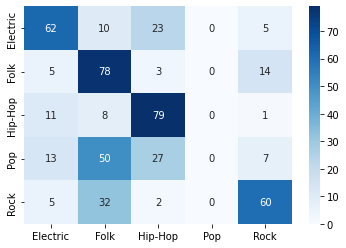

In [11]:
# Predict probabilities for each sample
predicted_probs = savedModelBaseline.predict(testData)

# Set up the test data generator and flow
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352, 3), batch_size=64, shuffle=False)

# Extract true class labels and predicted class indices
true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)
class_labels = list(test_data_flow.class_indices.keys())

confusion_mat_baseline = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(confusion_mat_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('Results/Plots/Confusion_Matrices/confusion_matrix_Baseline.png', bbox_inches='tight')



## Augmentation 1

8/8 [==============================] - 30s 4s/step
Found 495 images belonging to 5 classes.


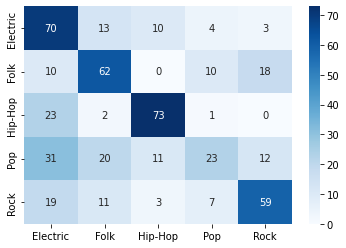

In [12]:
# Predict probabilities for each sample
predicted_probs = savedModelAug1.predict(testData)

# Set up the test data generator and flow
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352, 3), batch_size=64, shuffle=False)

# Extract true class labels and predicted class indices
true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)
class_labels = list(test_data_flow.class_indices.keys())

confusion_mat_aug1 = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(confusion_mat_aug1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('Results/Plots/Confusion_Matrices/confusion_matrix_Aug1.png', bbox_inches='tight')



## Diff Baseline to Aug1

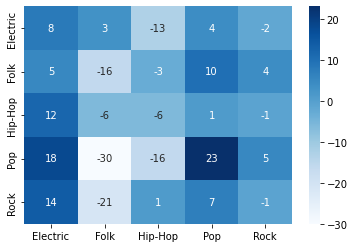

In [13]:
diffAug1 = confusion_mat_aug1 - confusion_mat_baseline
class_labels = list(test_data_flow.class_indices.keys())
sns.heatmap(diffAug1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('Results/Plots/Confusion_Matrices/confusion_matrix_diffAug1.png', bbox_inches='tight')


## Augmentation 2

8/8 [==============================] - 5s 640ms/step
Found 495 images belonging to 5 classes.


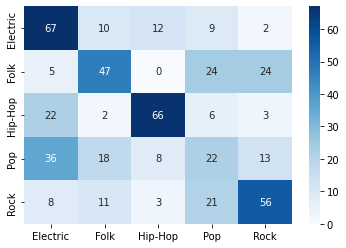

In [16]:
# Get predicted probabilities for each sample
predicted_probs = savedModelAug2.predict(testData)


# Get true class labels and predicted class indices
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352), batch_size=64, shuffle=False)

# Extract true class labels and predicted class indices
true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)
class_labels = list(test_data_flow.class_indices.keys())

confusion_mat_aug2 = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(confusion_mat_aug2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('Results/Plots/Confusion_Matrices/confusion_matrix_Aug2.png', bbox_inches='tight')


## Diff Baseline to Aug2

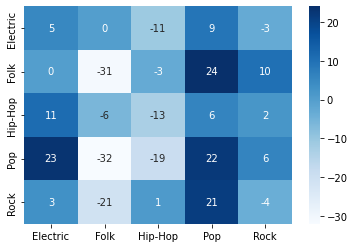

In [17]:
diffAug2 = confusion_mat_aug2 - confusion_mat_baseline
class_labels = list(test_data_flow.class_indices.keys())
sns.heatmap(diffAug2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('Results/Plots/Confusion_Matrices/confusion_matrix_diffAug2.png', bbox_inches='tight')


# Saliency Map

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Load your pre-trained model (replace this with your actual model loading code)
#savedModelBaseline = tf.keras.models.load_model("path_to_your_model")

def calculate_saliency(image_path, model):
    img = image.load_img(image_path, target_size=(235, 352))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_prediction = predictions[0, np.argmax(predictions)]
    gradient = tape.gradient(top_prediction, img_tensor)
    saliency_map = tf.reduce_max(gradient, axis=-1)
    
    # Normalize the saliency map
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))
    return saliency_map

genre_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]

for genre in genre_labels:
    image_directory = "SpectrogramData_Formatted/test/"+genre
    image_files = os.listdir(image_directory)

    # Initialize an array to store all the saliency maps
    all_saliency_maps = []

    # Loop through all image files
    count = 0
    items = os.listdir(image_directory)
    spectrogram_count = len(items)

    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        count += 1
        print(count/spectrogram_count)
        saliency_map = calculate_saliency(image_path, savedModelAug2)
        all_saliency_maps.append(saliency_map)

    # Calculate the average saliency map
    average_saliency_map = np.mean(all_saliency_maps, axis=0)

    # Normalize the average saliency map
    average_saliency_map = (average_saliency_map - np.min(average_saliency_map)) / (np.max(average_saliency_map) - np.min(average_saliency_map))

    # Visualize the average saliency map
    plt.imshow(average_saliency_map[0], cmap="jet")
    plt.axis("off")
    plt.savefig("saliencyAverage"+genre+".png", bbox_inches="tight")
    plt.show()


In [ ]:
calculate_saliency("SpectrogramData_Formatted/test/Pop/10.png", savedModelAug2)

In [ ]:
from PIL import Image

image_path_ = "SpectrogramData_Formatted/training_Noise+/Pop/3535.png"
image_path_Aug = "SpectrogramData_Formatted/training_Noise+/Pop/3535_Aug2.png"


img = image.load_img(image_path_, target_size=(235, 352))
img_array = image.img_to_array(img)

img = image.load_img(image_path_Aug, target_size=(235, 352))
img_arrayAug = image.img_to_array(img)

new_img = (img_arrayAug*1) - (img_array*1)

# Display the NumPy array as an image using matplotlib
plt.imshow(new_img)
plt.axis("off")  # Turn off axes
plt.show()

print(new_img)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load or generate your original and augmented spectrograms
original_spectrogram = image.load_img("SpectrogramData_Formatted/training_Noise+/Pop/3535.png", target_size=(235, 352))
original_spectrogram = image.img_to_array(original_spectrogram)
augmented_spectrogram = image.load_img("SpectrogramData_Formatted/training_Noise+/Pop/3535_Aug2.png", target_size=(235, 352))
augmented_spectrogram = image.img_to_array(augmented_spectrogram)

# Compute the absolute difference between the two spectrograms
spectrogram_difference = np.abs(augmented_spectrogram - original_spectrogram)

# Apply the threshold by setting differences below the threshold to zero
spectrogram_difference[spectrogram_difference > 0.8]

# Plot the original spectrogram
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_spectrogram, cmap='viridis', aspect='auto')
plt.title('Original Spectrogram')
plt.colorbar()

# Plot the augmented spectrogram
plt.subplot(1, 3, 2)
plt.imshow(augmented_spectrogram, cmap='viridis', aspect='auto')
plt.title('Augmented Spectrogram')
plt.colorbar()

# Plot the spectrogram difference
plt.subplot(1, 3, 3)
plt.imshow(spectrogram_difference, cmap='viridis', aspect='auto')
plt.title('Spectrogram Difference')
plt.colorbar()

plt.tight_layout()
plt.show()
